In [184]:
#import the nessesary libraries
import numpy as np
import matplotlib.pyplot as plt

### 1. Irreducible diagonal dominent

We can check if a matrix is diagonal dominant by writing the method on the given form
$$
\alpha_{i,j}T_{i,j} = \alpha_{i+1,j}T_{i+1,j} + \alpha_{i-1,j}T_{i-1,j} + \alpha_{i,j+1}T_{i,j+1} + \alpha_{i,j-1}T_{i,j-1}
$$
and check if the sum of right hand side coefficients are less of equal to the left hand side coefficient.
$$
|\alpha_{i,j}| \geq \sum_{l}^{} |\alpha_{l}| ,  \text{where} \, l=i-1,j, i+1,j, i,j+1, i,j-1
$$
in our case we se that all $\alpha_{l}$ are 1 and that $\alpha_{i,j} = 4$, thus the matrix A is diagonal dominant since $4 \geq 4$.
We also know that the matrix is irreducible as long as the diagonal is non-zero. Since $\alpha_{i,j} = 4$ we know the system is irreducible.

In [185]:
def Plot_beam(Domain, x_cords, y_cords, title):
    '''
    Descreption:
    Creates a colormesh plot of a given domain over it's x and y cords
    ---------------
    Input:
    Domain: A 2D array of temprature values in a given domain with length and hight equal to x and y 
    x_cords: 1D array with the x-cordinates in the domain
    y_cords: 1D array with the y-cordinates in the domain
    title: Title for the plot of the domain
    ---------------
    Output: NONE
    ---------------
    '''
    # Plotting
    fig, ax = plt.subplots(figsize=(8, 6))
    c = ax.pcolormesh(x_cords, y_cords, Domain, shading='auto')  # shading='auto' to avoid deprecation warnings
    fig.colorbar(c, ax=ax, boundaries=np.arange(20, 101, 1), label='Temperature')

    # Set labels and title
    ax.set_xlabel('X-axis (length)')
    ax.set_ylabel('Y-axis (length)')
    ax.set_title(title)

    plt.show()

In [186]:
def create_domain(h, StartTemp, left_bcs=20, right_bcs=100):
    '''
    Descreption:
    Creates a colormesh plot of a given domain over it's x and y cords
    ---------------
    Input:
    h: grid spacing which is used to calculate the residual for each iterations step
    StartTemp: Initial temperature for the internal grid points
    left_bcs: Temprature value for the left boundary contition (standart set to 20)
    right_bcs: Temprature value for the right boundary contition (standart set to 100)
    ---------------
    Output:
    D: A 2D array of temprature values in a given domain with length and hight equal to x and y
    Beam_bool: Boolian 2D array of wich values in the Domain that shal be itterated over
    x_arr: 1D array with x cordinates 
    y_arr: 1D array with y cordinates 
    ---------------
    '''
    # Calculate how many gridpints is nedded for our given length and hight for a unknown h
    XY_length = [10,14]
    N = int(XY_length[0] / h)
    M = int(XY_length[1] / h)

    # Create mesh grid
    x_arr = np.linspace(0, XY_length[0], N + 1)
    y_arr = np.linspace(0, XY_length[1], M + 1)
    # print(y)
    xv, yv = np.meshgrid(x_arr, y_arr)
    X_flat, Y_flat = xv.flatten(), yv.flatten()
    X_flat_copy = np.copy(X_flat)
    Y_flat_copy = np.copy(Y_flat)

    # Initialize Domain with starting temperature
    # Useing np.nan values sutch that we easily use any initial temperature for the beam
    Domain = np.full((M+1, N+1), np.nan)

    D_copy = Domain.flatten()
    # Initialize the start temperature in the domain
    for i, (X_flat,Y_flat) in enumerate(zip(X_flat,Y_flat)):
        if (X_flat <= 4.0 ) or (X_flat > 4.0 and (Y_flat >= 4.0 and Y_flat <= 10.0)):
            D_copy[i]= StartTemp

    # Reshape the flattend domain array back to a matrix
    D = np.reshape(D_copy,(M+1, N+1))

    # Set boundary conditions
    D[:, 0] = left_bcs
    for i in range(0, np.shape(D)[1]-1):
        if not np.isnan(D[0, i]): # Insure that nan values is not overwritten
            D[0, i] = left_bcs  # Left boundary
            D[-1, i] = left_bcs
    for j in range(0, np.shape(D)[0]-1):
        if not np.isnan(D[j, -1]): # Insure that nan values is not overwritten
            D[j, -1] = right_bcs  # Right boundary
        
    # Create a boolina array such that we know exactly whitch points to iterate over
    Beam_bool = (D==StartTemp)
    # Reinsure that the Diricle boundary points are not part of the boolian array, with this 
    # starting temperature can also be equal to eather elft or right boundary values
    Beam_bool[:, 0] = False
    Beam_bool[:,-1] = False
    Beam_bool[0, :] = False
    Beam_bool[-1,:] = False

    return D, Beam_bool, x_arr, y_arr

In [187]:
def GS_method(D, Beam_bool, h, T, tol=1e-6):
    '''
    Descreption:
    Solves the PDE for the heatequation of the initial domain D
    ---------------
    Input:
    D: A 2D array of temprature values in a given domain 
    Beam_bool: Boolian 2D array of wich values in the Domain that shal be itterated over
    h: grid spacing which is used to calculate the residual for each iterations step
    T: Maximum number of iterations
    tol: A given tolerance wich tels the method to end if the residual is less than the tolerance (Standart set ot 10^-6)
    ---------------
    Output:
    x_new: A 2D array of temprature values in a given domain which is a solution to D
    res_norm_fin: 1D array of residuals after each iteration step
    T_end: [int] Final number of iteration steps before the tolerance was met
    ---------------
    '''
    # Create a copy of the domain to do iterations over as well as a 
    x_curent = np.copy(D)
    r = np.zeros(np.shape(D))
    res_norm = np.zeros(T) # Array that will store the residuals for each iteration
    residual = np.zeros(np.count_nonzero(Beam_bool)) # Array with length equal to True elements in the boolian array
    x_new = np.copy(x_curent) # Make a kopy of the curent "frame"
    # Iteration starts
    for t in range(T):
        k=0 # Resets the count for which residual point value we are in
        for j in range(1, len(x_curent[0,:])-1):   
            for i in range(1, len(x_curent[:,0])-1):
                if Beam_bool[i][j]: # Only change interior nodes, i.e. only True values in the boolian array
                    if np.isnan(x_curent[i,j+1]):
                        # Check if the node to th right is nan valued
                        x_new[i,j] = 0.25*(x_new[i-1,j] + x_curent[i+1,j] + 2*x_new[i,j-1])
                    elif (np.isnan(x_curent[i-1,j])):
                        # Check if the node above is nan valued
                        x_new[i,j] = 0.25*(2*x_curent[i+1,j] + x_curent[i,j+1] + x_new[i,j-1])
                    elif (np.isnan(x_curent[i+1,j])):
                        # Check if the node under is nan valued
                        x_new[i,j] = 0.25*(2*x_new[i-1,j] + x_curent[i,j+1] + x_new[i,j-1])
                    else:
                        x_new[i,j] = 0.25*(x_new[i,j-1] + x_curent[i,j+1] + x_curent[i+1,j] + x_new[i-1,j])
        x_curent = np.copy(x_new)  # Update the "frame"

        # Calculate the residual for each updated point
        for j in range(1, len(x_new[0,:])-1):   
            for i in range(1, len(x_new[:,0])-1):
                if Beam_bool[i][j]:
                    if np.isnan(x_new[i,j+1]):
                        # Check if the node to th right is nan valued
                        r[i,j] = (1/h**2)*(x_new[i-1,j] + x_new[i+1,j] + 2*x_new[i,j-1] - 4*x_new[i,j])
                    elif (np.isnan(x_new[i-1,j])):
                        # Check if the node above is nan valued
                        r[i,j] = (1/h**2)*(2*x_new[i+1,j] + x_new[i,j+1] + x_new[i,j-1] - 4*x_new[i,j])
                    elif (np.isnan(x_new[i+1,j])):
                        # Check if the node under is nan valued
                        r[i,j] = (1/h**2)*(2*x_new[i-1,j] + x_new[i,j+1] + x_new[i,j-1] - 4*x_new[i,j])
                    else:
                        r[i,j] = (1/h**2)*(x_new[i,j-1] + x_new[i,j+1] + x_new[i+1,j] + x_new[i-1,j] - 4*x_new[i,j])
                    # Calculate the instence and store the value
                    residual[k] = r[i,j]
                    k +=1
        res_norm[t] = np.linalg.norm(residual)
        if res_norm[t] < tol: # stoping condition
            res_norm = np.copy(res_norm[:t+1]) # Shrink the lenght of the residuals to equal number of iterations
            T = t+1 # Store the end number of iterations
            break
         
    return x_new, res_norm, T

In [188]:
h = 0.5 #We let the grid size be 0.5
Num_itr = 5000 #Set a high number to give the method a chance to converge
tol = 1e-6

#Create the domain and use 50 as a initial temperature in the interior and the give n left and right boundary conditions
D_start, Beam_bool, x_arr, y_arr = create_domain(h, StartTemp=50, left_bcs=20, right_bcs=100)

#Use Gauss Seidle method to find a solution to our PDE
D_end, res_norm, T_end = GS_method(D_start, Beam_bool, h, Num_itr, tol=tol)

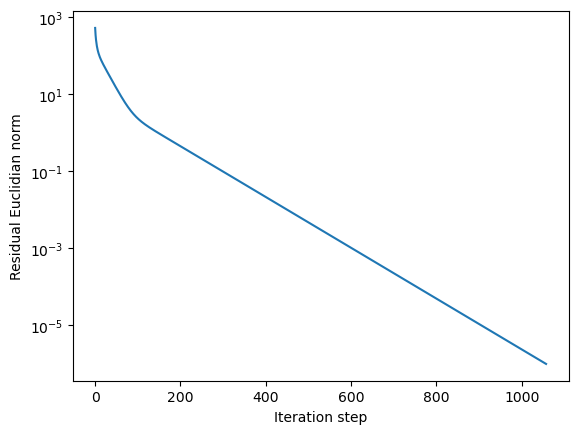

In [189]:
# Plot the residual (with standart Euclidian norm) for each iteration with a log scaling
plt.plot(range(T_end), res_norm)
plt.yscale("log")
plt.title("")
plt.xlabel("Iteration step")
plt.ylabel("Residual Euclidian norm")
plt.show()

We observ that for the first initial iterations the residual decreas quiet fast, but after about 200 iterations one could argue the result improves at such a rate that this amount of iterations is unnessesary.

### 3. Solution plot
After a given amount of iterations our method gives us a solution wich we can plot

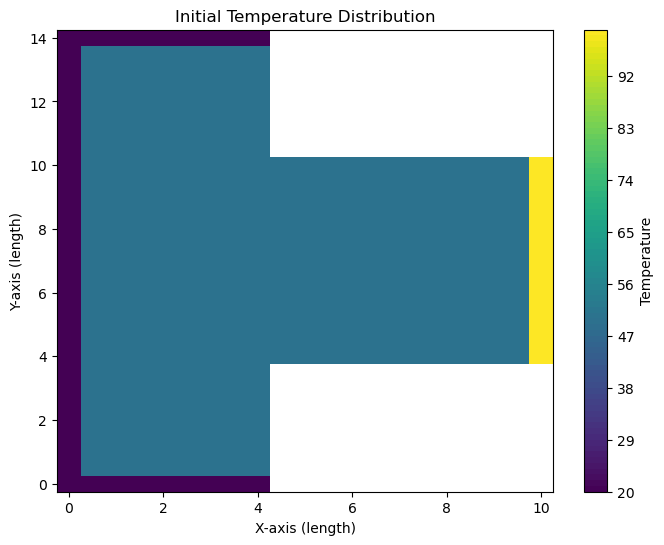

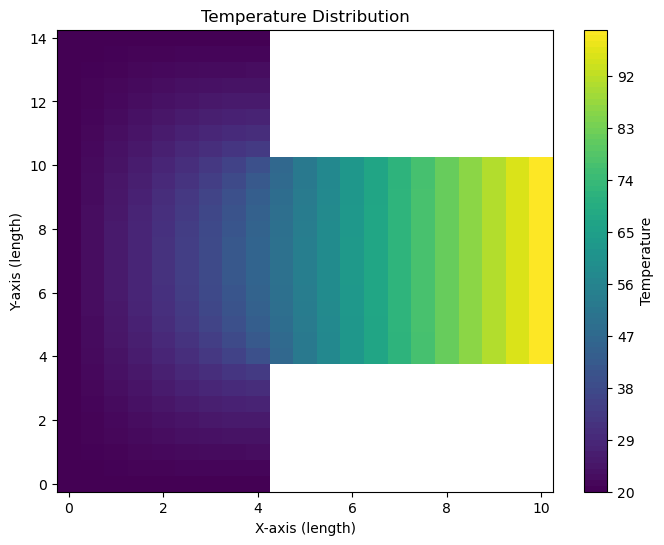

In [190]:
# Plot the initial state of the beam
Plot_beam(D_start, x_arr, y_arr, title='Initial Temperature Distribution')
# Plot the end state of the beam
Plot_beam(D_end, x_arr, y_arr, title='Temperature Distribution')

We see that the temperature disperces as expected.

### 4. Gauss Seidel with finer grid
We now continue to use the Gauss Seidel (GS) implimentation, but will now use a finer grid. We wil look at the same case but with $h=0.25$. Given that we know the error caused by the discretisation is $\mathcal{O}(h^2)$, which with our $h$ gives us $\mathcal{O}(6.25 \cdot 10^{-2})$. Thus by choosing a tolerance of $10^{-3}$ we garantee that our method converges.

In [191]:
h = 0.25 #We let the grid size be 0.5
Num_itr = 5000 #Set a high number to give the method a chance to converge
tol = 1e-3

#Create the domain and use 50 as a initial temperature in the interior and the give n left and right boundary conditions
D_start, Beam_bool, x_arr, y_arr = create_domain(h, StartTemp=50, left_bcs=20, right_bcs=100)

#Use Gauss Seidle method to find a solution to our PDE
D_end, res_norm, T_end = GS_method(D_start, Beam_bool, h, Num_itr, tol=tol)

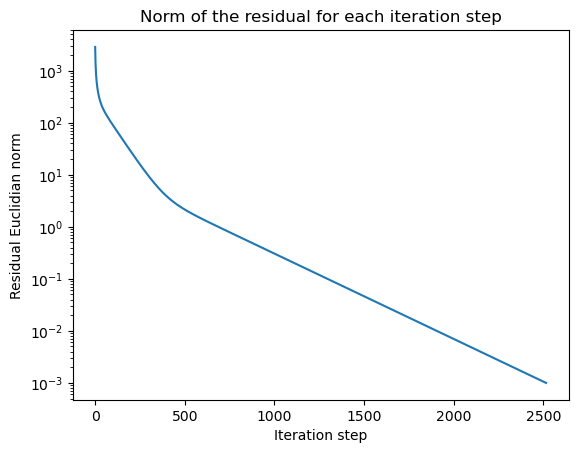

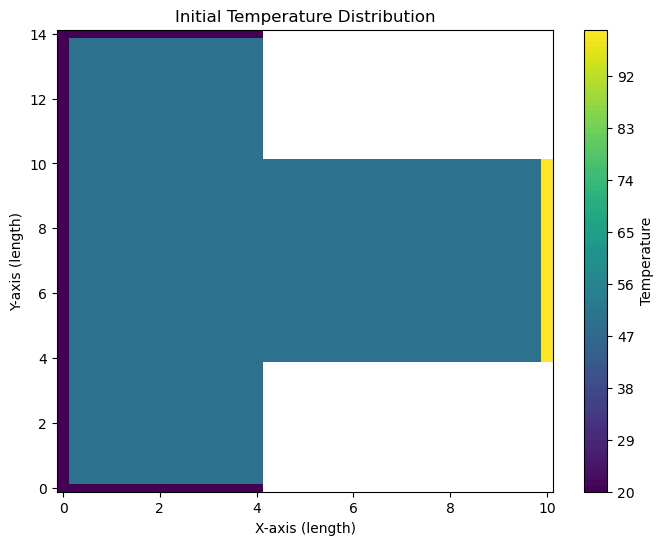

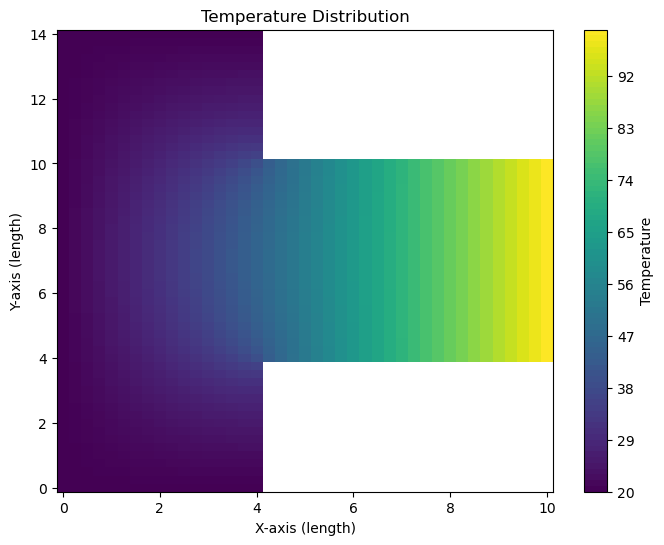

In [192]:
# Plot the residual (with standart Euclidian norm) for each iteration with a log scaling
plt.plot(range(T_end), res_norm)#, marker='')
plt.yscale("log")
plt.title("Norm of the residual for each iteration step")
plt.xlabel("Iteration step")
plt.ylabel("Residual Euclidian norm")
plt.show()

# Plot the initial state of the beam
Plot_beam(D_start, x_arr, y_arr, title='Initial Temperature Distribution')
# Plot the end state of the beam
Plot_beam(D_end, x_arr, y_arr, title='Temperature Distribution')

### 5. Implimenting Successive over-relaxation (SOR)
We will now impliment SOR method and go back to using a gridspacing of $h=0.5$. We want to find the optimal relaxation parameter ($w$) for our problem. We will find this parameter by ploting a graph wich shows how many iterations was needed to reach the given tolerance for a given $w$.

In [193]:
def SOR_method(D, Beam_bool, h, T, tol=1e-10, w=1):
    '''
    Descreption:
    Solves the PDE for the heatequation of the initial domain D
    ---------------
    Input:
    D: A 2D array of temprature values in a given domain 
    Beam_bool: Boolian 2D array of wich values in the Domain that shal be itterated over
    h: grid spacing which is used to calculate the residual for each iterations step
    T: Maximum number of iterations
    tol: A given tolerance wich tels the method to end if the residual is less than the tolerance
    w: relaxation parameter used in SOR varies between (1,2). Standard input is 1 which makes the method the GS method
    ---------------
    Output:
    x_new: A 2D array of temprature values in a given domain which is a solution to D
    res_norm_fin: 1D array of residuals after each iteration step
    T_end: [int] Final number of iteration steps before the tolerance was met
    ---------------
    '''
    # Create a copy of the domain to do iterations over as well as a 
    x_curent = np.copy(D)
    r = np.zeros(np.shape(D))
    res_norm = np.zeros(T) # Array that will store the residuals for each iteration
    residual = np.zeros(np.count_nonzero(Beam_bool)) # Array with length equal to True elements in the boolian array
    x_new = np.copy(x_curent) # Make a kopy of the curent "frame"
    # Iteration starts
    for t in range(T):
        k=0 # Resets the count for which residual point value we are in
        for j in range(1, len(x_curent[0,:])-1):   
            for i in range(1, len(x_curent[:,0])-1):
                if Beam_bool[i][j]: # Only change interior nodes, i.e. only True values in the boolian array
                    if np.isnan(x_curent[i,j+1]):
                        # Check if the node to th right is nan valued
                        x_new[i,j] = (1-w)*x_curent[i,j] + w*0.25*(x_new[i-1,j] + x_curent[i+1,j] + 2*x_new[i,j-1])
                    elif (np.isnan(x_curent[i-1,j])):
                        # Check if the node above is nan valued
                        x_new[i,j] = (1-w)*x_curent[i,j] + w*0.25*(2*x_curent[i+1,j] + x_curent[i,j+1] + x_new[i,j-1])
                    elif (np.isnan(x_curent[i+1,j])):
                        # Check if the node under is nan valued
                        x_new[i,j] = (1-w)*x_curent[i,j] + w*0.25*(2*x_new[i-1,j] + x_curent[i,j+1] + x_new[i,j-1])
                    else:
                        x_new[i,j] = (1-w)*x_curent[i,j] + w*0.25*(x_new[i,j-1] + x_curent[i,j+1] + x_curent[i+1,j] + x_new[i-1,j])
        x_curent = np.copy(x_new)  # Update the "frame"
        
        # Calculate the residual for each updated point
        for j in range(1, len(x_new[0,:])-1):   
            for i in range(1, len(x_new[:,0])-1):
                if Beam_bool[i][j]:
                    if np.isnan(x_new[i,j+1]):
                        # Check if the node to th right is nan valued
                        r[i,j] = (1/h**2)*(x_new[i-1,j] + x_new[i+1,j] + 2*x_new[i,j-1] - 4*x_new[i,j])
                    elif (np.isnan(x_new[i-1,j])):
                        # Check if the node above is nan valued
                        r[i,j] = (1/h**2)*(2*x_new[i+1,j] + x_new[i,j+1] + x_new[i,j-1] - 4*x_new[i,j])
                    elif (np.isnan(x_new[i+1,j])):
                        # Check if the node under is nan valued
                        r[i,j] = (1/h**2)*(2*x_new[i-1,j] + x_new[i,j+1] + x_new[i,j-1] - 4*x_new[i,j])
                    else:
                        r[i,j] = (1/h**2)*(x_new[i,j-1] + x_new[i,j+1] + x_new[i+1,j] + x_new[i-1,j] - 4*x_new[i,j])
                    residual[k] = r[i,j]
                    k +=1
        res_norm[t] = np.linalg.norm(residual)
        if res_norm[t] < tol: # stoping condition
            res_norm = np.copy(res_norm[:t+1]) # Shrink the lenght of the residuals to equal number of iterations
            T = t+1 # Store the end number of iterations
            break
         
    return x_new, res_norm, T

In [194]:
h = 0.5
D_start, Beam_bool, x_arr, y_arr = create_domain(h=0.5, StartTemp=50, left_bcs=20, right_bcs=100)

Num_itr = 5000
tol = 1e-2 # Can use tol=10^-2 given O(h^2)
spacing = 0.01 # w increasing by 0.01
w_vals = np.linspace(1,2,int(1/spacing)+1) # Array of incresing valus of w
w_vals = w_vals[:-1] # remove w=2 since this never converges
print(w_vals)
w_iterations = np.zeros(len(w_vals)) # Array to store the number of iterations for a given value of w

# loop to find the number of iterations needed befor the tolerance is met for a given w
for i in range(0,len(w_vals)):
    w_iterations[i] = SOR_method(D_start, Beam_bool, h, Num_itr, tol=tol, w=w_vals[i])[-1]

[1.   1.01 1.02 1.03 1.04 1.05 1.06 1.07 1.08 1.09 1.1  1.11 1.12 1.13
 1.14 1.15 1.16 1.17 1.18 1.19 1.2  1.21 1.22 1.23 1.24 1.25 1.26 1.27
 1.28 1.29 1.3  1.31 1.32 1.33 1.34 1.35 1.36 1.37 1.38 1.39 1.4  1.41
 1.42 1.43 1.44 1.45 1.46 1.47 1.48 1.49 1.5  1.51 1.52 1.53 1.54 1.55
 1.56 1.57 1.58 1.59 1.6  1.61 1.62 1.63 1.64 1.65 1.66 1.67 1.68 1.69
 1.7  1.71 1.72 1.73 1.74 1.75 1.76 1.77 1.78 1.79 1.8  1.81 1.82 1.83
 1.84 1.85 1.86 1.87 1.88 1.89 1.9  1.91 1.92 1.93 1.94 1.95 1.96 1.97
 1.98 1.99]


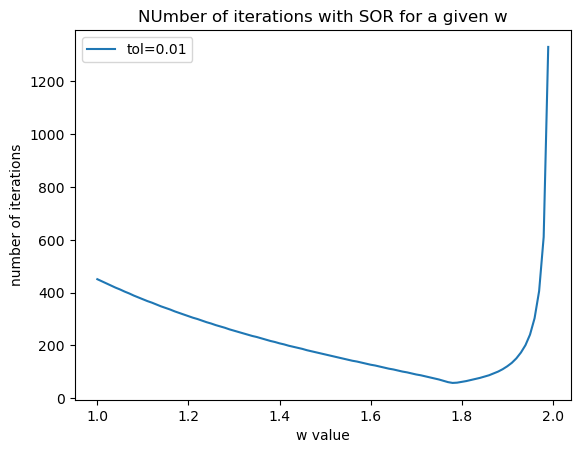

In [195]:
# Plot the number of iterations needed to reach a given tolerance for a given w
plt.plot(w_vals, w_iterations, label=f'tol={tol}')
plt.title(f"NUmber of iterations with SOR for a given w")
plt.xlabel("w value")
plt.ylabel("number of iterations")
plt.legend()
plt.show()

We can observe that when $w$ increases from 1 (which is GS) the number of iteration needed to reach the tolerance condition decreases. This holds until about $w=1.8$ where it starts to increas again. 

### 6. New Neumann condition
We now consider a new Neumann condition for the beam for where the boundary of the beam tutches the wall.
$$
\frac{\partial T}{\partial n} + \gamma T = 0
$$
where $\gamma$ is some parameter. We want to look at how the differance equations at the boundary changes and what value $\gamma$ must have for A to still be irreducible diagonal dominant.

Using the same method for the fictitious temperature for the derivitive where the stencil overshoots the domain, in adition to the $\gamma T$ term we get 3 cases over the Neumann boundary as before
$$
\begin{aligned}
\frac{\partial T}{\partial x} + \gamma T = 0 \\
\frac{1}{2h}(T_{i+1,j} - T_{i-1,j}) + \gamma T_{i,j} = 0 \\
T_{i+1,j} =  T_{i-1,j} - 2h\gamma T_{i,j} \\
\end{aligned}
$$
For when the stencil overshooths the Neumann boundary to the right
$$
\begin{aligned}
\frac{\partial T}{\partial y} + \gamma T = 0 \\
\frac{1}{2h}(T_{i,j+1} - T_{i,j-1}) + \gamma T_{i,j} = 0 \\
T_{i,j+1} =  T_{i,j-1} - 2h\gamma T_{i,j} \\
\end{aligned}
$$
When the stencil overshooths the Neumann boundary above, and
$$
\begin{aligned}
\frac{\partial T}{\partial y} + \gamma T = 0 \\
\frac{1}{2h}(-T_{i,j+1} + T_{i,j-1}) + \gamma T_{i,j} = 0 \\
T_{i,j-1} =  T_{i,j+1} - 2h\gamma T_{i,j} \\
\end{aligned}
$$
when it overshoots below. We also observ that the sign in the last equation is fliped since the normal vector is pointing down. We can now for the 3 cases subsetute the fictitious with the equations above,
$$
\begin{aligned}
4T_{i,j} = T_{i+1,j} + T_{i-1,j} + T_{i,j+1} + T_{i,j-1} \\
4T_{i,j} = T_{i-1,j} - 2h\gamma T_{i,j} + T_{i-1,j} + T_{i,j+1} + T_{i,j-1} \\
(4 +2h\gamma) T_{i,j} = 2T_{i-1,j} + T_{i,j+1} + T_{i,j-1} \\
\end{aligned}
$$
and equaly for the above and below cases
$$
\begin{aligned}
4T_{i,j} = T_{i+1,j} + T_{i-1,j} + T_{i,j-1} - 2h\gamma T_{i,j} + T_{i,j-1} \\
(4 +2h\gamma) T_{i,j} = T_{i+1,j} + T_{i-1,j} + 2T_{i,j-1} \\
\end{aligned}
$$
$$
\begin{aligned}
4T_{i,j} = T_{i+1,j} + T_{i-1,j} + T_{i,j-1} - 2h\gamma T_{i,j} + T_{i,j-1} \\
(4 +2h\gamma) T_{i,j} = T_{i+1,j} + T_{i-1,j} + 2T_{i,j+1} \\
\end{aligned}
$$
Checking for diagonal dominance in each of thise cases we see that they are all the same. Thus we have
$$
\begin{aligned}
|4 +2h\gamma| \geq 4 \\
16 +16h\gamma + 4h^{2}\gamma^{2} \geq 16    \\
16h\gamma + 4h^{2}\gamma^{2} \geq 0 \\
4h\gamma (4 + h\gamma) \geq 0 \\
\gamma(\gamma+\frac{4}{h}) \geq 0 \\
\end{aligned}
$$
For this to equal zero we see that eather $\gamma = 0$ or $\gamma = -\frac{4}{h}$. By evaluating the product with this in mind we see that for values of $\gamma<-\frac{4}{h}$ we get that $\gamma(\gamma+\frac{4}{h}) > 0$. For values between $-\frac{4}{h} > \gamma > 0$ the product becomes negativ and the inequality does not hold. For $\gamma>0$ we also get that the inequality holds. Thus we have a band consisting of values of $\gamma$ where, $\gamma \leq -\frac{4}{h}$ and $\gamma \geq 0$, that are akseptable values of $\gamma$ to achive diagonal dominence.

For the matrix to be irreducible it must hold that the constant $4 +2h\gamma \ne 0$, thus it must hold that $\gamma \ne -\frac{2}{h}$. Since $-\frac{2}{h}$ is outside of the domain where we have diagonal dominance. Thus by insuring we have diagonal dominance we will always have irreducibility, but by insuring we cant automaticaly expect the matrix to be diagonal dominant.
